# Notebook 02: Experimentos de Entrenamiento para Segmentación Dermatológica

**Objetivos del experimento:**
1. Entrenar y comparar tres arquitecturas: U-Net, Attention U-Net, Residual U-Net
2. Analizar el impacto de diferentes funciones de pérdida
3. Evaluar el rendimiento en el conjunto de validación
4. Documentar el proceso completo para el TFM

**Metodología:**
- Dataset: ISIC 2018 (2594 imágenes train, 100 val)
- Preprocesamiento: Redimensionado a 256x256, normalización ImageNet
- Entrenamiento: 5 épocas por modelo (para comparación rápida)
- Evaluación: Dice Score, IoU, Precisión, Recall

## 1. Configuración inicial

In [1]:
# Importaciones básicas
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo para gráficos
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.titleweight'] = 'bold'

# Añadir src al path - CORRECCIÓN AQUÍ
import os
PROJECT_ROOT = Path.cwd().parent if "notebooks" in str(Path.cwd()) else Path.cwd()
sys.path.append(str(PROJECT_ROOT))

# Importaciones personalizadas
from src.data_preparation.data_loader import MedicalDataLoader
from src.models import UNet, AttentionUNet, ResidualUNet
from src.models.losses import DiceLoss, FocalLoss, CombinedLoss
from src.models.metrics import SegmentationMetrics

# Configurar dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"📱 Dispositivo: {device}")
if device.type == 'cuda':
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memoria disponible: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

📱 Dispositivo: cuda
   GPU: NVIDIA GeForce RTX 3060
   Memoria disponible: 12.88 GB


## 2. Configuración de experimentos

In [2]:
# Configuración experimental
EXPERIMENT_CONFIG = {
    'base_path': '../data',
    'target_size': (256, 256),
    'batch_size': 8,
    'num_workers': 4,
    'epochs': 5,  # Para experimentos rápidos
    'learning_rate': 1e-4,
    'weight_decay': 1e-5,
    
    'experiments': [
        {
            'name': 'U-Net Básica',
            'model_class': 'UNet',
            'model_kwargs': {'features': [64, 128, 256, 512]},
            'loss': 'combined',
            'loss_kwargs': {'losses': ['bce', 'dice'], 'weights': [0.5, 0.5]}
        },
        {
            'name': 'Attention U-Net',
            'model_class': 'AttentionUNet',
            'model_kwargs': {'features': [64, 128, 256, 512]},
            'loss': 'combined',
            'loss_kwargs': {'losses': ['bce', 'dice'], 'weights': [0.5, 0.5]}
        },
        {
            'name': 'Residual U-Net',
            'model_class': 'ResidualUNet',
            'model_kwargs': {'features': [64, 128, 256, 512]},
            'loss': 'combined',
            'loss_kwargs': {'losses': ['bce', 'dice'], 'weights': [0.5, 0.5]}
        }
    ]
}

print("📋 CONFIGURACIÓN EXPERIMENTAL")
print("="*50)
for key, value in EXPERIMENT_CONFIG.items():
    if key != 'experiments':
        print(f"{key}: {value}")

📋 CONFIGURACIÓN EXPERIMENTAL
base_path: ../data
target_size: (256, 256)
batch_size: 8
num_workers: 4
epochs: 5
learning_rate: 0.0001
weight_decay: 1e-05


## 3. Preparación de datos


📂 PREPARANDO DATOS PARA ENTRENAMIENTO
Cargando datasets...
📂 Creando datasets...
  ✅ Train: 2594 imágenes
  ✅ Val: 100 imágenes
  ✅ Test: 1000 imágenes
🔄 Creando DataLoaders...
⚖️  Creando weighted sampler...
  Sampler creado con 2594 pesos
  ✅ Train Loader: 324 batches
  ✅ Val Loader: 13 batches
  ✅ Test Loader: 125 batches
✅ Datasets creados:
   - Train: 2594 imágenes
   - Val: 100 imágenes
   - Test: 1000 imágenes

🎨 Visualizando batch de entrenamiento de ejemplo...


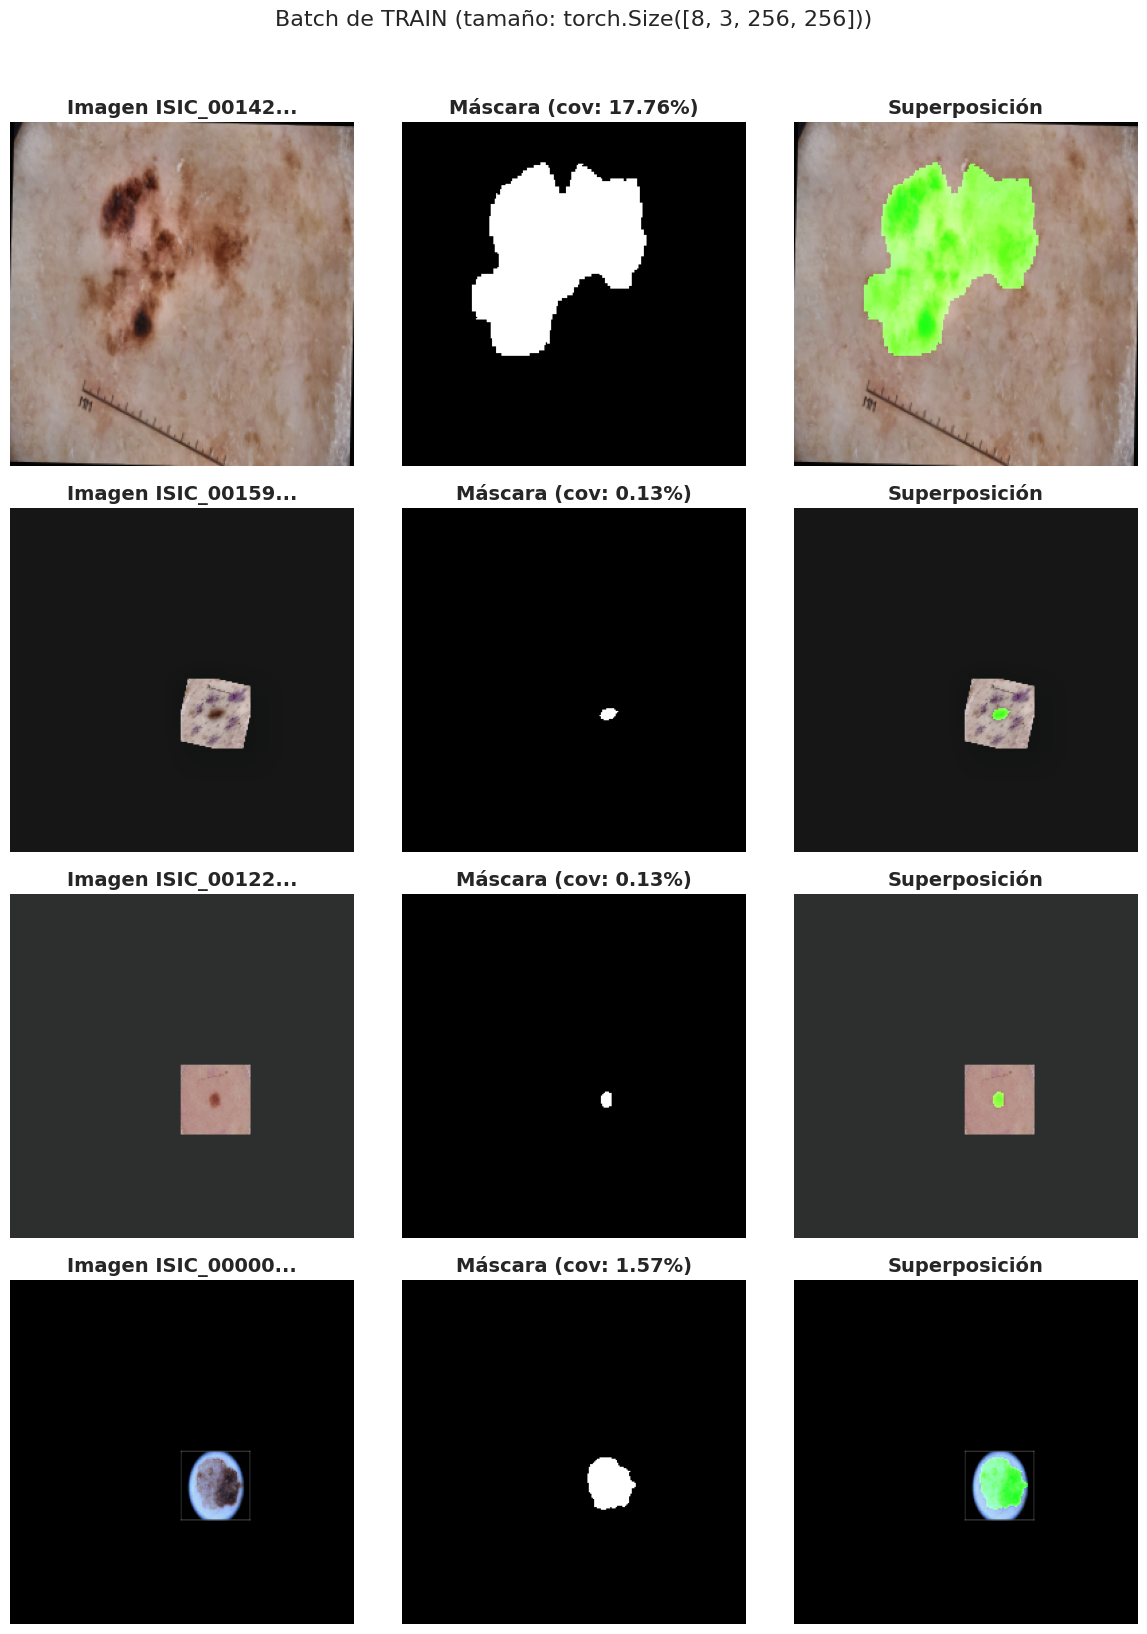


📊 Estadísticas del batch (train):
  Batch shape: torch.Size([8, 3, 256, 256])
  Rango imagen: [-2.118, 2.553]
  Rango máscara: [0.000, 1.000]
  Cobertura media batch: 10.653%


In [3]:
print("\n📂 PREPARANDO DATOS PARA ENTRENAMIENTO")
print("="*50)

# Crear DataLoader
data_loader = MedicalDataLoader(
    base_path=EXPERIMENT_CONFIG['base_path'],
    batch_size=EXPERIMENT_CONFIG['batch_size'],
    target_size=EXPERIMENT_CONFIG['target_size'],
    num_workers=EXPERIMENT_CONFIG['num_workers'],
    use_class_balancing=True,
    debug=False
)

# Crear datasets y dataloaders
print("Cargando datasets...")
data_loader.create_datasets(use_processed=True, augment_train=True)
data_loader.create_dataloaders(shuffle_train=True)

print(f"✅ Datasets creados:")
print(f"   - Train: {len(data_loader.train_loader.dataset)} imágenes")
print(f"   - Val: {len(data_loader.val_loader.dataset)} imágenes")
print(f"   - Test: {len(data_loader.test_loader.dataset) if data_loader.test_loader else 0} imágenes")

# Visualizar un batch de ejemplo
print("\n🎨 Visualizando batch de entrenamiento de ejemplo...")
data_loader.visualize_batch(num_samples=4, phase='train')

## 4. Función de entrenamiento por experimento

In [6]:
def train_experiment(exp_config, train_loader, val_loader, device, save_dir=None):
    """
    Entrena un modelo según la configuración experimental
    
    Args:
        exp_config: Configuración del experimento
        train_loader: DataLoader de entrenamiento
        val_loader: DataLoader de validación
        device: Dispositivo (cuda/cpu)
        save_dir: Directorio para guardar resultados
        
    Returns:
        Diccionario con resultados del entrenamiento
    """
    
    print(f"\n🚀 INICIANDO EXPERIMENTO: {exp_config['name']}")
    print("-" * 50)
    
    # Crear modelo
    if exp_config['model_class'] == 'UNet':
        model = UNet(**exp_config.get('model_kwargs', {}))
    elif exp_config['model_class'] == 'AttentionUNet':
        model = AttentionUNet(**exp_config.get('model_kwargs', {}))
    elif exp_config['model_class'] == 'ResidualUNet':
        model = ResidualUNet(**exp_config.get('model_kwargs', {}))
    else:
        raise ValueError(f"Modelo no soportado: {exp_config['model_class']}")
    
    model.to(device)
    print(f"✅ Modelo creado: {model.__class__.__name__}")
    print(f"   Parámetros: {sum(p.numel() for p in model.parameters()):,}")
    
    # Crear función de pérdida
    loss_name = exp_config.get('loss', 'combined')
    loss_kwargs = exp_config.get('loss_kwargs', {})
    
    if loss_name == 'bce':
        criterion = nn.BCEWithLogitsLoss()
    elif loss_name == 'dice':
        criterion = DiceLoss()
    elif loss_name == 'combined':
        criterion = CombinedLoss(**loss_kwargs)
    else:
        raise ValueError(f"Pérdida no soportada: {loss_name}")
    
    print(f"✅ Función de pérdida: {criterion.__class__.__name__}")
    
    # Optimizador
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=EXPERIMENT_CONFIG['learning_rate'],
        weight_decay=EXPERIMENT_CONFIG['weight_decay']
    )
    
    # Scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3
    )
    
    # Métricas
    train_metrics = SegmentationMetrics()
    val_metrics = SegmentationMetrics()
    
    # Historial
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_dice': [],
        'val_dice': [],
        'train_iou': [],
        'val_iou': [],
        'learning_rate': []
    }
    
    # Entrenamiento
    best_val_dice = 0.0
    best_model_state = None
    
    for epoch in range(1, EXPERIMENT_CONFIG['epochs'] + 1):
        print(f"\n📊 Época {epoch}/{EXPERIMENT_CONFIG['epochs']}")
        
        # Fase de entrenamiento
        model.train()
        train_metrics.reset()
        epoch_train_loss = 0.0
        
        for batch in train_loader:
            images = batch['image'].to(device)
            masks = batch['mask'].to(device)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Actualizar métricas
            epoch_train_loss += loss.item()
            train_metrics.update(outputs, masks)
        
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_results = train_metrics.compute()
        
        # Fase de validación
        model.eval()
        val_metrics.reset()
        epoch_val_loss = 0.0
        
        with torch.no_grad():
            for batch in val_loader:
                images = batch['image'].to(device)
                masks = batch['mask'].to(device)
                
                outputs = model(images)
                loss = criterion(outputs, masks)
                
                epoch_val_loss += loss.item()
                val_metrics.update(outputs, masks)
        
        avg_val_loss = epoch_val_loss / len(val_loader)
        val_results = val_metrics.compute()
        
        # Actualizar scheduler
        scheduler.step(avg_val_loss)
        
        # Guardar historial
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_dice'].append(train_results['dice'])
        history['val_dice'].append(val_results['dice'])
        history['train_iou'].append(train_results['iou'])
        history['val_iou'].append(val_results['iou'])
        history['learning_rate'].append(optimizer.param_groups[0]['lr'])
        
        # Mostrar resultados
        print(f"   Train - Loss: {avg_train_loss:.4f}, Dice: {train_results['dice']:.4f}, IoU: {train_results['iou']:.4f}")
        print(f"   Val   - Loss: {avg_val_loss:.4f}, Dice: {val_results['dice']:.4f}, IoU: {val_results['iou']:.4f}")
        print(f"   LR: {optimizer.param_groups[0]['lr']:.2e}")
        
        # Guardar mejor modelo
        if val_results['dice'] > best_val_dice:
            best_val_dice = val_results['dice']
            best_model_state = model.state_dict().copy()
            print(f"   💾 Nuevo mejor modelo (Dice: {best_val_dice:.4f})")
    
    # Resultados finales
    results = {
        'model': model,
        'history': history,
        'best_val_dice': best_val_dice,
        'best_model_state': best_model_state,
        'config': exp_config
    }
    
    print(f"\n✅ Experimento completado: {exp_config['name']}")
    print(f"   Mejor Val Dice: {best_val_dice:.4f}")
    print(f"   Épocas entrenadas: {EXPERIMENT_CONFIG['epochs']}")
    
    return results

## 5. Ejecución de todos los experimentos

In [ ]:
print("\n" + "="*60)
print("🧪 EJECUTANDO TODOS LOS EXPERIMENTOS")
print("="*60)

# Directorio para guardar resultados
results_dir = Path('experiments/notebook_experiments')
results_dir.mkdir(parents=True, exist_ok=True)

# Ejecutar cada experimento
all_results = {}

for exp_config in EXPERIMENT_CONFIG['experiments']:
    exp_name = exp_config['name'].replace(' ', '_').lower()
    exp_save_dir = results_dir / exp_name
    exp_save_dir.mkdir(exist_ok=True)
    
    # Entrenar
    results = train_experiment(
        exp_config=exp_config,
        train_loader=data_loader.train_loader,
        val_loader=data_loader.val_loader,
        device=device,
        save_dir=exp_save_dir
    )
    
    # Guardar resultados
    all_results[exp_config['name']] = results
    
    # Guardar modelo
    if results['best_model_state'] is not None:
        model_path = exp_save_dir / 'best_model.pth'
        torch.save({
            'model_state_dict': results['best_model_state'],
            'config': exp_config,
            'history': results['history'],
            'best_val_dice': results['best_val_dice']
        }, model_path)
        print(f"💾 Modelo guardado en: {model_path}")
    
    # Guardar historial como CSV
    history_df = pd.DataFrame(results['history'])
    history_path = exp_save_dir / 'training_history.csv'
    history_df.to_csv(history_path, index=False)
    print(f"💾 Historial guardado en: {history_path}")
    
    print("-" * 50)

print("\n🎉 TODOS LOS EXPERIMENTOS COMPLETADOS!")


🧪 EJECUTANDO TODOS LOS EXPERIMENTOS

🚀 INICIANDO EXPERIMENTO: U-Net Básica
--------------------------------------------------
✅ Modelo creado: UNet
   Parámetros: 31,043,521
✅ Función de pérdida: CombinedLoss

📊 Época 1/5
   Train - Loss: 0.5724, Dice: 0.5674, IoU: 0.4225
   Val   - Loss: 0.7178, Dice: 0.5954, IoU: 0.4265
   LR: 1.00e-04
   💾 Nuevo mejor modelo (Dice: 0.5954)

📊 Época 2/5
   Train - Loss: 0.4246, Dice: 0.6686, IoU: 0.5228
   Val   - Loss: 0.3294, Dice: 0.7863, IoU: 0.6514
   LR: 1.00e-04
   💾 Nuevo mejor modelo (Dice: 0.7863)

📊 Época 3/5
   Train - Loss: 0.3559, Dice: 0.6846, IoU: 0.5432
   Val   - Loss: 0.3191, Dice: 0.7687, IoU: 0.6283
   LR: 1.00e-04

📊 Época 4/5
   Train - Loss: 0.2950, Dice: 0.7186, IoU: 0.5798
   Val   - Loss: 0.3133, Dice: 0.7704, IoU: 0.6301
   LR: 1.00e-04

📊 Época 5/5
   Train - Loss: 0.2675, Dice: 0.7234, IoU: 0.5852
   Val   - Loss: 0.2768, Dice: 0.8029, IoU: 0.6791
   LR: 1.00e-04
   💾 Nuevo mejor modelo (Dice: 0.8029)

✅ Experimento com

## 6. Visualización comparativa de resultados

In [ ]:
print("\n📊 VISUALIZANDO RESULTADOS COMPARATIVOS")
print("="*50)

# Crear figura para comparación
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
colors = plt.cm.Set3(np.linspace(0, 1, len(all_results)))

# Gráfico 1: Curvas de pérdida
ax = axes[0, 0]
for (name, results), color in zip(all_results.items(), colors):
    ax.plot(results['history']['train_loss'], label=f'{name} (Train)', color=color, linewidth=2)
    ax.plot(results['history']['val_loss'], label=f'{name} (Val)', color=color, linewidth=2, linestyle='--')
ax.set_title('Curvas de Pérdida', fontsize=14, fontweight='bold')
ax.set_xlabel('Época')
ax.set_ylabel('Pérdida')
ax.legend()
ax.grid(True, alpha=0.3)

# Gráfico 2: Curvas de Dice Score
ax = axes[0, 1]
for (name, results), color in zip(all_results.items(), colors):
    ax.plot(results['history']['train_dice'], label=f'{name} (Train)', color=color, linewidth=2)
    ax.plot(results['history']['val_dice'], label=f'{name} (Val)', color=color, linewidth=2, linestyle='--')
ax.set_title('Curvas de Dice Score', fontsize=14, fontweight='bold')
ax.set_xlabel('Época')
ax.set_ylabel('Dice Score')
ax.legend()
ax.grid(True, alpha=0.3)

# Gráfico 3: Curvas de IoU
ax = axes[0, 2]
for (name, results), color in zip(all_results.items(), colors):
    ax.plot(results['history']['train_iou'], label=f'{name} (Train)', color=color, linewidth=2)
    ax.plot(results['history']['val_iou'], label=f'{name} (Val)', color=color, linewidth=2, linestyle='--')
ax.set_title('Curvas de IoU', fontsize=14, fontweight='bold')
ax.set_xlabel('Época')
ax.set_ylabel('IoU')
ax.legend()
ax.grid(True, alpha=0.3)

# Gráfico 4: Comparación final de métricas
ax = axes[1, 0]
model_names = list(all_results.keys())
final_val_dice = [results['history']['val_dice'][-1] for results in all_results.values()]
final_val_iou = [results['history']['val_iou'][-1] for results in all_results.values()]

x = np.arange(len(model_names))
width = 0.35

bars1 = ax.bar(x - width/2, final_val_dice, width, label='Dice Final', color='skyblue')
bars2 = ax.bar(x + width/2, final_val_iou, width, label='IoU Final', color='lightcoral')

ax.set_title('Métricas Finales (Val)', fontsize=14, fontweight='bold')
ax.set_xlabel('Modelo')
ax.set_ylabel('Valor')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Añadir valores en barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
               f'{height:.3f}', ha='center', va='bottom', fontsize=10)

# Gráfico 5: Mejor Dice Score por modelo
ax = axes[1, 1]
best_dice = [results['best_val_dice'] for results in all_results.values()]
bars = ax.bar(model_names, best_dice, color=colors)
ax.set_title('Mejor Dice Score por Modelo', fontsize=14, fontweight='bold')
ax.set_xlabel('Modelo')
ax.set_ylabel('Mejor Dice Score')
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.grid(True, alpha=0.3, axis='y')

for bar, dice in zip(bars, best_dice):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
           f'{dice:.3f}', ha='center', va='bottom', fontweight='bold')

# Gráfico 6: Resumen estadístico
ax = axes[1, 2]
ax.axis('off')

# Crear tabla de resumen
summary_data = []
for name, results in all_results.items():
    summary_data.append([
        name,
        f"{results['history']['train_loss'][-1]:.4f}",
        f"{results['history']['val_loss'][-1]:.4f}",
        f"{results['history']['val_dice'][-1]:.4f}",
        f"{results['history']['val_iou'][-1]:.4f}",
        f"{results['best_val_dice']:.4f}"
    ])

table = ax.table(cellText=summary_data,
                 colLabels=['Modelo', 'Train Loss', 'Val Loss', 'Val Dice', 'Val IoU', 'Best Dice'],
                 cellLoc='center',
                 loc='center',
                 colWidths=[0.15, 0.12, 0.12, 0.12, 0.12, 0.12])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)

# Resaltar mejor modelo
best_dice_idx = np.argmax(best_dice)
for i in range(len(summary_data[0])):
    table[(best_dice_idx + 1, i)].set_facecolor('#90EE90')  # Verde claro

ax.set_title('Resumen Comparativo', fontsize=14, fontweight='bold', y=0.95)

plt.suptitle('Comparativa de Experimentos de Entrenamiento', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()

# Guardar figura
fig_path = results_dir / 'experiments_comparison.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"💾 Gráfico comparativo guardado en: {fig_path}")

## 7. Análisis de resultados

In [ ]:
print("\n🔍 ANÁLISIS DE RESULTADOS")
print("="*50)

# Calcular estadísticas
analysis_results = []

for name, results in all_results.items():
    history = results['history']
    
    # Calcular mejoras
    dice_improvement = history['val_dice'][-1] - history['val_dice'][0]
    loss_improvement = history['val_loss'][0] - history['val_loss'][-1]
    
    # Calcular overfitting (diferencia train-val)
    overfitting_dice = history['train_dice'][-1] - history['val_dice'][-1]
    overfitting_loss = history['val_loss'][-1] - history['train_loss'][-1]
    
    analysis_results.append({
        'Modelo': name,
        'Dice Inicial': history['val_dice'][0],
        'Dice Final': history['val_dice'][-1],
        'Mejora Dice': dice_improvement,
        'Mejor Dice': results['best_val_dice'],
        'Overfitting Dice': overfitting_dice,
        'Loss Inicial': history['val_loss'][0],
        'Loss Final': history['val_loss'][-1],
        'Mejora Loss': loss_improvement,
        'Overfitting Loss': overfitting_loss,
        'Épocas para converger': np.argmax(history['val_dice']) + 1
    })

# Crear DataFrame
analysis_df = pd.DataFrame(analysis_results)
analysis_df = analysis_df.sort_values('Mejor Dice', ascending=False)

print("\n📈 ANÁLISIS COMPARATIVO")
print(analysis_df.to_string(index=False))

# Guardar análisis
analysis_path = results_dir / 'analysis_results.csv'
analysis_df.to_csv(analysis_path, index=False)
print(f"\n💾 Análisis guardado en: {analysis_path}")

## 8. Conclusiones preliminares

In [ ]:
print("\n" + "="*60)
print("🎯 CONCLUSIONES PRELIMINARES DE LOS EXPERIMENTOS")
print("="*60)

# Mejor modelo
best_model_row = analysis_df.iloc[0]
print(f"\n🏆 MEJOR MODELO: {best_model_row['Modelo']}")
print(f"   • Dice Score final: {best_model_row['Dice Final']:.4f}")
print(f"   • Mejor Dice Score: {best_model_row['Mejor Dice']:.4f}")
print(f"   • Mejora durante entrenamiento: {best_model_row['Mejora Dice']:.4f}")
print(f"   • Overfitting (Dice): {best_model_row['Overfitting Dice']:.4f}")

# Hallazgos generales
print("\n🔑 HALLAZGOS GENERALES:")
for idx, row in analysis_df.iterrows():
    print(f"   • {row['Modelo']}: Mejoró {row['Mejora Dice']:.4f} en Dice, "
          f"convergió en {row['Épocas para converger']} épocas")

# Recomendaciones
print("\n💡 RECOMENDACIONES PARA EXPERIMENTOS FUTUROS:")
print("   1. Aumentar número de épocas para ver convergencia completa")
print("   2. Probar diferentes learning rates y schedulers")
print("   3. Experimentar con funciones de pérdida alternativas")
print("   4. Aplicar técnicas de regularización para reducir overfitting")
print("   5. Validar en conjunto de test para evaluación final")

## 9. Guardar resultados completos

In [ ]:
print("\n💾 GUARDANDO RESULTADOS COMPLETOS")
print("="*50)

# Crear archivo de resumen del experimento
experiment_summary = {
    'configuracion': EXPERIMENT_CONFIG,
    'resultados': {name: {
        'best_val_dice': results['best_val_dice'],
        'final_val_dice': results['history']['val_dice'][-1],
        'final_val_iou': results['history']['val_iou'][-1],
        'model_class': results['config']['model_class'],
        'loss_function': results['config']['loss']
    } for name, results in all_results.items()},
    'analisis': analysis_results,
    'timestamp': pd.Timestamp.now().isoformat()
}

# Guardar como JSON
import json
summary_path = results_dir / 'experiment_summary.json'
with open(summary_path, 'w') as f:
    json.dump(experiment_summary, f, indent=2, default=str)

print(f"✅ Resumen del experimento guardado en: {summary_path}")

# Mostrar rutas de todos los archivos generados
print("\n📁 ARCHIVOS GENERADOS:")
for file_path in results_dir.rglob('*'):
    if file_path.is_file():
        print(f"   • {file_path.relative_to(results_dir)}")

print("\n" + "="*60)
print("✅ NOTEBOOK DE EXPERIMENTOS COMPLETADO EXITOSAMENTE")
print("="*60)